In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from torch import optim
import json
from PIL import Image
import io
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import pickle
import urllib.request
import requests
from matplotlib.pyplot import imshow

In [18]:
#Helper Functions
def imshow_tensor(img):
    img = inv_normalize(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def saveim(img, name):
    save_image(img, name)
def readim(name):
    image = Image.open(name)
    x = TF.to_tensor(image)
    tform = transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    x = tform(x)
    x.unsqueeze_(0)
    return x
def stack(w,size):
    dim = len(torch.flatten(w))
    if dim == size:
        return w
    ide = torch.eye(dim, requires_grad=True, dtype=torch.float, device=device)
    zer = torch.zeros([1,dim], requires_grad=True, dtype=torch.float, device=device)

    n = size // dim
    m = size % dim
    nsum = torch.zeros([1,1,size,1], requires_grad=True, dtype=torch.float, device=device)
    ides = torch.cat(n*[ide])
    if m != 0:
        zers = torch.cat(m*[zer])
        mat = torch.cat([ides,zers])
    else:
        mat = ides
    nsum = nsum + torch.matmul(mat,w)
    if m == 0:
        return nsum
    t = []
    for i in range(m):
        t.append(torch.tensor([1 if x == i else 0 for x in range(dim)],requires_grad=True, dtype=torch.float), device=device)

    mat2 = torch.cat([torch.cat(dim*n*[zer]),torch.stack(t)])
    nsum = nsum + torch.matmul(mat2,w)
    return nsum
def gamma_correction(img, factor):
    return ((img+0.5)**factor)-0.5

(1300, 1300)


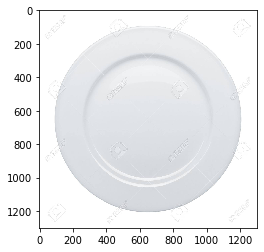

In [19]:
CLASS_URL = 'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
class_dict = pickle.load(urllib.request.urlopen(CLASS_URL))

IMG_URL = "https://previews.123rf.com/images/korovin/korovin1205/korovin120500113/13808681-plate-on-white-background.jpg"
classidx = 923
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))
print(img.size)
imshow(img)

In [20]:
model_img_size = 224
model_transform = transforms.Compose([transforms.Resize((model_img_size,model_img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


print(type(img))
img_input = model_transform(img)
img_input = img_input.unsqueeze(0)
img_input = Variable(img_input)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet101(pretrained=True)
pretrained_model.to(device)
pretrained_model.eval()
prediction = pretrained_model(img_input)
prediction_label = prediction.data.numpy().argmax()
print(prediction_label)
print(class_dict[prediction_label])

567
frying pan, frypan, skillet


<class 'torch.Tensor'>


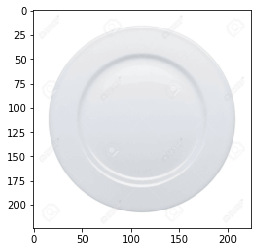

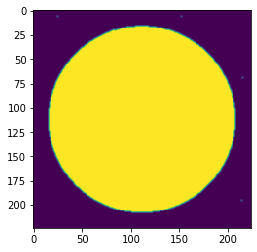

In [22]:
def get_object_mask(input_image):
    #print(test[-3][:])
    test = inv_normalize(input_image)
    test = np.uint8(test.numpy()*255).transpose((1,2,0))
    #test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
    th, thgray = cv2.threshold(gray, 238, 255, cv2.THRESH_BINARY_INV); 
    #blurred = cv2.GaussianBlur(thgray, (9, 9), 0)
    th, blurred = cv2.threshold(thgray, 50, 255, cv2.THRESH_BINARY); 
    edged = cv2.Canny(blurred, 1, 250, L2gradient=True)   
    #imgplot = plt.imshow(blurred, cmap="gray")
    #plt.show()
    #imshow(input_image[0])
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)    #finding_contours
    #imgplot = plt.imshow(closed, cmap="gray")
    #plt.show()
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []    # only for this example
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(closed, [approx], -1, (0, 255, 0), 2)    
    th, im_th = cv2.threshold(closed, 254, 255, cv2.THRESH_BINARY_INV);    
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 0);    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)    # Combine the two images to get the foreground.
    im_out = im_th ^ im_floodfill_inv
    im_out = cv2.GaussianBlur(im_out, (3, 3), 0)
    return im_out
print(type(img_input[0]))
imshow_tensor(img_input[0])
imgplot = plt.imshow(get_object_mask(img_input[0]))
plt.show()

In [23]:
# The input time signal
sz = 228
c = 0.3
w = torch.rand([1,1,sz,1], requires_grad=True, dtype=torch.float, device=device)
targidx = 200
#Does not work since no useful gradients
#Aw = torch.rand([1], requires_grad=True, dtype=torch.float, device=device) #amplitude and frequency
#sample = torch.linspace(0, 4, sz, dtype=torch.float, device=device)  #Sampling rate, do the math to get this
#w = torch.sin(100*Aw[0]*sample).view([1,1,sz,1]) #Sample the sine wave

mask = torch.tensor(get_object_mask(img_input[0].cpu()), dtype=torch.float, device=device)
mask = mask / torch.max(mask)
#The shutter function is encoded into the convolution layer
lay = torch.nn.Conv1d(1,1,5)

#Manually setting the weights and bias so the  shutter acts as a box filter
lay.weight.data = torch.full([1,1,5,1], .2, requires_grad=True, dtype=torch.float, device=device)
lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)

#Target and original class labels
target = torch.tensor([targidx], dtype=torch.long, device=device) #Yield
orig = torch.tensor([classidx], dtype=torch.long, device=device)


lr = 1e-1
n_epochs = 200
optimizer = optim.SGD([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

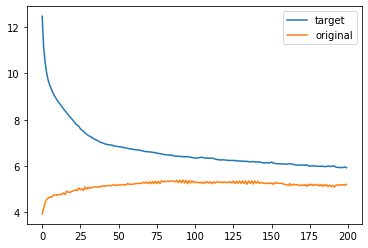

In [24]:
targloss = []
origloss = []
for epoch in range(n_epochs):
    
    # Compute g(y) to get X_adv
    #gy = lay(ft)    
    #w = torch.tanh(gy)
    
    oot = stack(w,228)
    new_w = .5 * (torch.tanh(oot) + 1)
    #new_w = .5 * (oot + 1) #Method using Sin, does not work, no gradients
    gy = lay(new_w)             #Convolution of ft and the shutter
    gy_mask = gy * mask
    #gy_mask = gy_mask + (1 - mask)
    inp = (c + (1-c)*gy_mask)*img_input         #gy is broadcasted to match the shape of input_im
    out = pretrained_model(inp)
    #Calculate Loss
    loss = loss_fn(out, target)
    targloss.append(loss.data)
    origloss.append(loss_fn(out,orig))
    loss.backward(retain_graph=True)
    
    
    optimizer.step()
    
    optimizer.zero_grad()
    
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

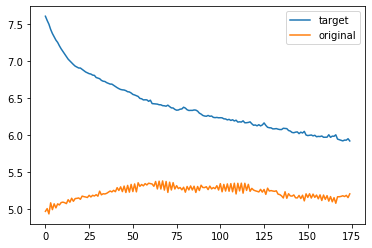

In [25]:
plt.plot(targloss[25:], label="target")
plt.plot(origloss[25:], label="original")
plt.legend()
plt.show()

torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224])


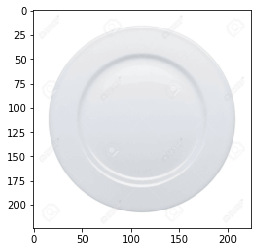

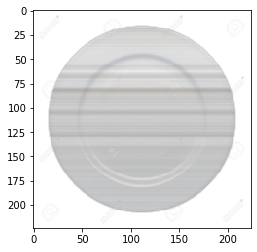

In [26]:
cmask = torch.tensor(gy_mask.detach().numpy()[0], device=device)
img_out = (1-mask)*img_input + mask*(c+(1-c)*cmask)*img_input
print(img_input.size())
print(cmask.size())
imshow_tensor(img_input[0])
imshow_tensor(img_out[0])

In [27]:
prediction = pretrained_model(img_out)
prediction_label = prediction.data.numpy().argmax()
print(prediction_label)
print(class_dict[prediction_label])

712
Petri dish
